We want to create an initial set of template waveforms, one template being a three-component seismogram.

This is what we want to keep in mind to have for all three channels:
- Windows with both P- and S- pick
- Only one earthquake in the window
- Raw SNR > 2 for P-wave
- Raw SNR > 3 for S-wave
- Prioritize higher magnitudes first

In [2]:
import obspy
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
import time; import datetime
from obspy.core.utcdatetime import UTCDateTime
from obspy.clients.fdsn.client import Client

In [3]:
def read_files(base_folder):
    ''' Reads in earthquake catalog files from CSS format into useful pandas dataframes
    
        Inputs:
        base_folder = string containing name of year and month of interest, e.g. '2019_01'
        
        Outputs dataframes:
        assoc
        arrivals
        origin
    '''
    
    
    base_dir = 'catalog_css/'+base_folder+'/'
    
    arr_files = glob.glob(base_dir + 'catalog_XO_*arrival')
    assoc_files = glob.glob(base_dir + 'catalog_XO_*assoc')
    origin_files = glob.glob(base_dir + 'catalog_XO_*origin')
    
    # Read data into pandas dataframe
    arrivals = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in arr_files])
    assoc = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in assoc_files])
    origin = pd.concat([pd.read_csv(f,header=None,delim_whitespace=True) for f in origin_files])

    # Rename some columns for clarity:
    assoc=assoc.rename(columns={0: "arrivalid", 1: "originid",2:"stationcode",3:"phase"})
    origin = origin.rename(columns={4:'originid',3:'epochtime',20:'magnitude'})
    arrivals=arrivals.rename(columns={2: "arrivalid", 6: "channel",0:"stationcode", 1:'epochtime',7:'phase'})
    
    return(assoc,arrivals,origin)

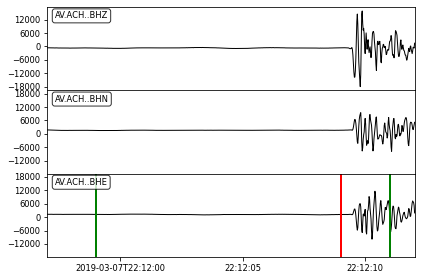

144.80710345


Press Enter to continue... 


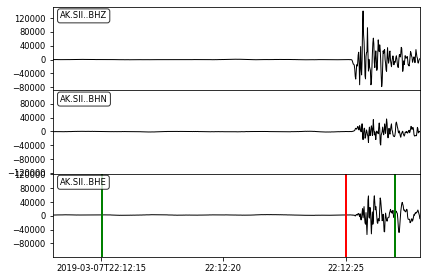

108.839678229


Press Enter to continue... 


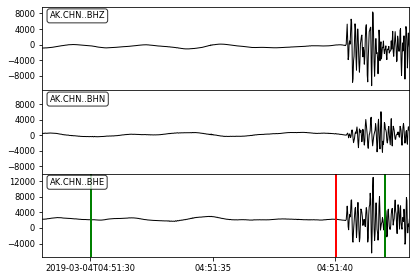

47.0758578796


Press Enter to continue... 


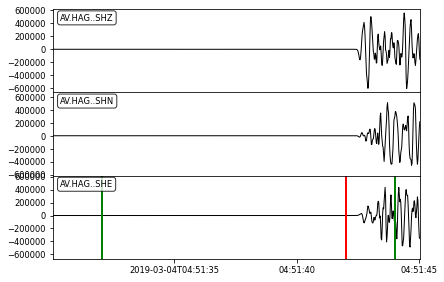

5281.68256698


Press Enter to continue... 


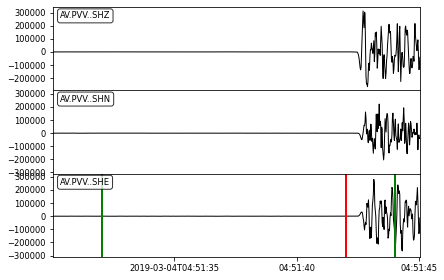

1436.02551083


Press Enter to continue... 


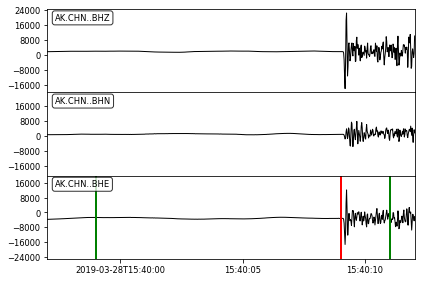

54.6807696995


Press Enter to continue... 


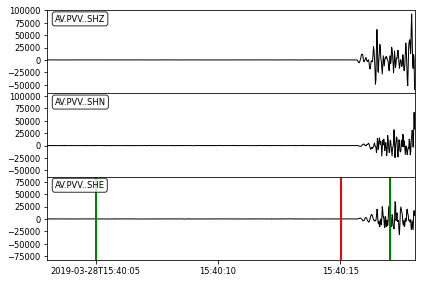

196.41528484


Press Enter to continue... 


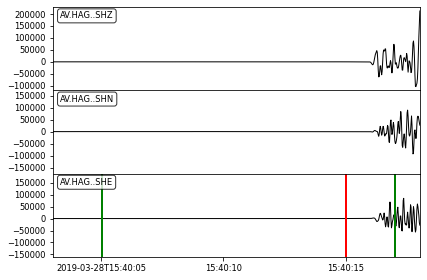

1689.27809059


Press Enter to continue... 


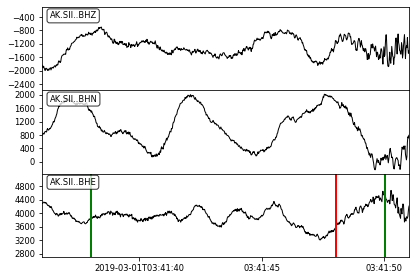

19.2291498523


Press Enter to continue... 


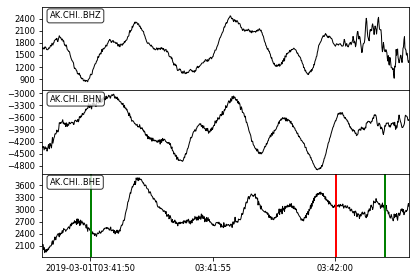

9.7291552003


KeyboardInterrupt: Interrupted by user

In [96]:
# Load catalog info for one month
month = '2019_03'
(assoc,arrivals,origin) = read_files(month)

# Sort events by magnitude, descending
origin = origin.sort_values(by=['magnitude'],ascending=False)
origin_ids = origin['originid']

# Loop through events
for id in origin_ids:

    # Get arrivals associated with this earthquake
    subset = assoc.loc[assoc['originid']==id]
    arrival_subset = arrivals.iloc[subset['arrivalid']-1]
    arrival_subset.reset_index(drop=True,inplace=True)
    
    # Get station names
    stations = arrival_subset['stationcode']

    # Get list of stations that have both P and S pick
    repeats = []
    for station in stations:
        sub = arrival_subset.loc[(arrival_subset['stationcode']==station)]
        if len(np.unique(sub['phase']))>1:
            repeats.append(station)

    repeat_subset = arrival_subset.loc[(arrival_subset['stationcode'].isin(repeats))]
    # repeat_subset = repeat_subset.sort_values(by=['stationcode'])
    repeat_subset = repeat_subset.drop_duplicates(subset=['stationcode'])
    repeat_subset.reset_index(drop=True,inplace=True)
    # print(repeat_subset)

    
    # Loop through picks
    for i in range(0,len(repeat_subset)):
        pick = repeat_subset.iloc[i]
        
        # Skip global array stations that have low sample rates and complicated location codes
        if len(pick['stationcode'])>3:
            continue
            
        # P arrival time:
        pick_epoch = pick['epochtime']
        basetime = datetime.datetime.utcfromtimestamp(pick_epoch).strftime('%Y-%m-%dT%H:%M:%S.%m')
        
        # We want the streams for x minutes before and after the pick time:
        t1 = UTCDateTime(basetime)-datetime.timedelta(minutes = 2)
        t2 = UTCDateTime(basetime)+datetime.timedelta(minutes = 10)

        # Now we query the data from IRIS for each of the stations 20 min before and after the origin time, and add it to the master stream:
        client = Client("IRIS")

        # Download the streams INCLUDING the instrument response:
        channel_base = pick['channel'][0:2]
        st = client.get_waveforms("XO,AK,AV",pick['stationcode'], "--",channel_base+'*', t1, t2,attach_response=True)
      
        # Plot the raw waveform:
        %matplotlib inline
        fig = plt.figure()
        t11 = UTCDateTime(basetime)-datetime.timedelta(seconds = 12)
        t22 = UTCDateTime(basetime)+datetime.timedelta(seconds = 3)
        st.plot(fig = fig,starttime=t11,endtime=t22) 
        plt.axvline(x=UTCDateTime(basetime),linewidth=2, color='r')
        plt.axvline(x=UTCDateTime(basetime)-datetime.timedelta(seconds = 10),linewidth=2,color='g')
        plt.axvline(x=UTCDateTime(basetime)+datetime.timedelta(seconds = 2),linewidth=2,color='g')
        plt.show()
        # st.spectrogram(log=True, title=str(st[0].stats.starttime))
        
        # Calculate SNR of arrival
        data = st[0].data
        sr = int(st[0].stats.sampling_rate)
        psampleind = ((2*60)*sr)-1
        snr_num = max(abs(data[psampleind:(psampleind+(2*sr))]))
        snr_denom = np.std(data[(psampleind-(10*sr)):psampleind])
        snr = snr_num/snr_denom
        print(snr)


        input("Press Enter to continue...")